概要：本节主要介绍主成分分析的优化。

1.主成分分析。

主成分分析（Principal Component Analysis）是目前为止最流行的降维算法。首先它找到接
近数据集分布的超平面，然后将所有的数据都投影到这个超平面上。

* 保留（最大）方差

在将训练集投影到较低维超平面之前，您首先需要选择正确的超平面。

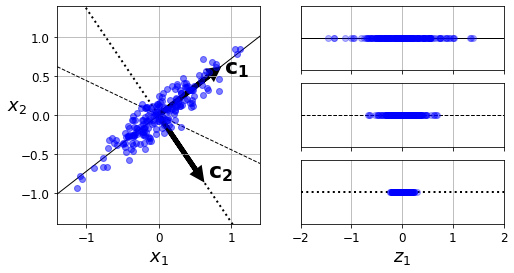

In [14]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

左侧是一个简单的二维数据集，以及三个不同的轴（即一维超平面）。图右边是将数据集投影到每个
轴上的结果。正如你所看到的，投影到实线上保留了最大方差，而在点线上的投影只保留了
非常小的方差，投影到虚线上保留的方差则处于上述两者之间。

选择保持最大方差的轴看起来是合理的，因为它很可能比其他投影损失更少的信息。证明这
种选择的另一种方法是，选择这个轴使得将原始数据集投影到该轴上的均方距离最小。这是
就 PCA 背后的思想，相当简单。

PCA 寻找训练集中可获得最大方差的轴。

* 主成分的方向不稳定：如果您稍微打乱一下训练集并再次运行 PCA，则某些新
PC 可能会指向与原始 PC 方向相反。但是，它们通常仍位于同一轴线上。在某些情况
下，一对 PC 甚至可能会旋转或交换，但它们定义的平面通常保持不变。

2.如何寻找训练集的主成分

那么如何找到训练集的主成分呢？幸运的是，有一种称为奇异值分解（SVD）的标准矩阵分
解技术，可以将训练集矩阵 X 分解为三个矩阵 U·Σ·V^T 的点积，其中 V^T 包含我们想要的所
有主成分：

$$ V^T = \left ( C_1,\cdots , C_n \right ) $$

可以用numpy中的svd函数获得主成分：

In [15]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [16]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

3.投影到 d 维空间

一旦确定了所有的主成分，你就可以通过将数据集投影到由前 d 个主成分构成的超平面上，
从而将数据集的维数降至 d 维。选择这个超平面可以确保投影将保留尽可能多的方差。

为了将训练集投影到超平面上，可以简单地通过计算训练集矩阵 X 和 Wd 的点积， Wd 定义
为包含前 d 个主成分的矩阵（即由 V^T 的前 d 列组成的矩阵），如下公式：

$$ X_{d-proj} = X \cdot W_d $$

下面的 Python 代码将训练集投影到由前两个主成分定义的超平面上：

In [17]:
W2=Vt.T[:,:2]
X2D=X_centered.dot(W2)

Scikit-Learn 的 PCA 类使用 SVD 分解来实现，就像我们之前做的那样。以下代码应用 PCA
将数据集的维度降至两维（请注意，它会自动处理数据的中心化）：

In [18]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
X2D=pca.fit_transform(X)

将 PCA 转化器应用于数据。集后，可以使用 components_ 访问每一个主成分。

In [19]:
pca.components_.T[:,0]

array([-0.93636116, -0.29854881, -0.18465208])

4.方差解释率。

另一个非常有用的信息是每个主成分的方差解释率，可通过 explained_variance_ratio_ 变量
获得。它表示位于每个主成分轴上的数据集方差的比例。

pca.explained_variance_ratio_

这表明，84.2% 的数据集方差位于第一轴，14.6% 的方差位于第二轴。第三轴的这一比例不
到1.2％，因此可以认为它可能没有包含什么信息。

5.选择正确的维度。

通常我们倾向于选择加起来到方差解释率能够达到足够占比（例如 95%）的维度的数量，而
不是任意选择要降低到的维度数量。当然，除非您正在为数据可视化而降低维度 -- 在这种情
况下，您通常希望将维度降低到 2 或 3。

下面的代码在不降维的情况下进行 PCA，然后计算出保留训练集方差 95% 所需的最小维数：

In [20]:
pca=PCA()
pca.fit(X)
cumsum=np.cumsum(pca.explained_variance_ratio_)
d=np.argmax(cumsum>=0.95)+1

In [21]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839, 0.01119554])

将 n_components 设置为 0.0 到 1.0 之间的浮点数，表明您希望保留的方差比率：

In [22]:
pca=PCA(n_components=0.95)
X_reduced=pca.fit_transform(X)

另一种选择是画出方差解释率关于维数的函数,曲线中
通常会有一个肘部，方差解释率停止快速增长。您可以将其视为数据集的真正的维度。

6.PCA压缩。

通过应用 PCA 投影的逆变换，也可以将缩小的数据集解压缩回 784 维，如下所示：

In [23]:
from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [24]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [26]:
d

154

In [29]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [30]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

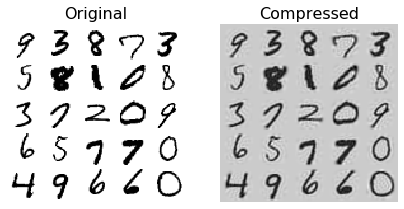

In [31]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)


压缩后的图像和原始图像。